# [2021: Lightweight image classifier for CIFAR-10](https://www.jsstec.org/xml/30582/30582.pdf)

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, AveragePooling2D, Dropout, GlobalAveragePooling2D, Dense, Concatenate, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [3]:
# Load the cifar10 dataset and split train/test
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Split train/valid from the training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=5)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


## Chuẩn hóa data

In [4]:
# # Chuẩn hóa dữ liệu về khoảng 0-1
# X_train = X_train.astype('float32') / 255.0
# X_test = X_test.astype('float32') / 255.0

# # Chuyển nhãn sang one-hot encoding
# y_train = tf.keras.utils.to_categorical(y_train, 10)
# y_test = tf.keras.utils.to_categorical(y_test, 10)

In [5]:
import numpy as np
print(np.max(X_train))

255


# 1. Build model

In [6]:
def main_block(inputs, filters):
    # Extra convolution layer before main block
    x = Conv2D(filters, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # First path: pointwise -> depthwise -> pointwise convolution
    x1 = Conv2D(filters, (1, 1), padding='same')(inputs)
    x1 = DepthwiseConv2D((3, 3), padding='same')(x1)
    x1 = Conv2D(filters, (1, 1), padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x1 = ReLU()(x1)

    # Second path: depthwise -> pointwise convolution
    x2 = DepthwiseConv2D((3, 3), padding='same')(inputs)
    x2 = Conv2D(filters, (1, 1), padding='same')(x2)
    x2 = BatchNormalization()(x2)
    x2 = ReLU()(x2)

    # Third path: direct connection
    x3 = x

    # Concatenate all three paths
    output = Concatenate()([x1, x2, x3])

    return output

def transition_block(inputs, filters):
    # Pointwise convolution
    x = Conv2D(filters, (1, 1), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Average pooling for downsampling
    x = AveragePooling2D(pool_size=(2, 2))(x)

    return x

def build_model(input_shape, num_classes, model_name="Lightweight_CNN"):
    inputs = Input(shape=input_shape)

    # Initial layer: pointwise convolution + batchnorm + ReLU
    x = Conv2D(256, (1, 1), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    filters = 256
    for _ in range(4):
        x = main_block(x, filters)
        x = transition_block(x, filters)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs, name=model_name)

    return model

model = build_model((32, 32, 3), 10, model_name="extraconv_Lightweight_Model")
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003, decay=1e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Tính tổng số tham số
total_params = model.count_params()
print(f"Total number of parameters: {total_params}")

Total number of parameters: 3978762


/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


# 2. Callback

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def cosine_decay_with_warmup(global_step, warmup_steps, total_steps, base_lr, warmup_lr=1e-4):
    if global_step < warmup_steps:
        warmup_percent_done = global_step / warmup_steps
        warmup_lr = warmup_lr + (base_lr - warmup_lr) * warmup_percent_done
        return float(warmup_lr)
    else:
        cosine_decay = 0.5 * (1 + np.cos(np.pi * (global_step - warmup_steps) / (total_steps - warmup_steps)))
        return float(base_lr * cosine_decay)

class WarmupCosineDecayScheduler(tf.keras.callbacks.Callback):
    def __init__(self, warmup_steps, total_steps, base_lr, warmup_lr=1e-4):
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.base_lr = base_lr
        self.warmup_lr = warmup_lr
        self.global_step = 0

    def on_batch_begin(self, batch, logs=None):

        # Tính toán learning rate mới với hàm cosine decay + warmup
        lr = cosine_decay_with_warmup(self.global_step, self.warmup_steps, self.total_steps, self.base_lr, self.warmup_lr)

        # Đảm bảo giá trị lr là float và cập nhật learning rate
        self.model.optimizer.learning_rate.assign(lr)
        self.global_step += 1

# Áp dụng callback trong quá trình huấn luyện
total_steps = len(X_train) // 32 * 200  # Số lượng bước toàn bộ
warmup_steps = total_steps // 10        # Warm-up trong 10% thời gian huấn luyện

warmup_cosine_decay = WarmupCosineDecayScheduler(
    warmup_steps=warmup_steps,
    total_steps=total_steps,
    base_lr=0.001
)

# Tạo các callback
checkpoint = ModelCheckpoint(filepath='epoch-{epoch:02d}.keras',
                             save_best_only=True,
                             monitor='val_accuracy',
                             mode='max',
                             verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-5, cooldown=2, verbose=1)

# 3. Data augmentation

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np

# Hàm Random Erasing
def random_erasing(image, probability=0.5, sl=0.02, sh=0.4, r1=0.3):
    if np.random.uniform(0, 1) > probability:
        return image

    h, w, _ = image.shape
    area = h * w

    for _ in range(100):
        target_area = np.random.uniform(sl, sh) * area
        aspect_ratio = np.random.uniform(r1, 1 / r1)

        h_erase = int(round(np.sqrt(target_area * aspect_ratio)))
        w_erase = int(round(np.sqrt(target_area / aspect_ratio)))

        if h_erase < h and w_erase < w:
            x1 = np.random.randint(0, h - h_erase)
            y1 = np.random.randint(0, w - w_erase)

            image[x1:x1 + h_erase, y1:y1 + w_erase, :] = np.random.uniform(0, 1)
            return image

    return image

# Áp dụng Random Erasing trong ImageDataGenerator
def custom_preprocessing(image):
    image = random_erasing(image)
    return image


# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=15,
    zoom_range=0.2,
    fill_mode='nearest',
    preprocessing_function=custom_preprocessing
)

# 4. Train model

In [9]:
# !rm *.keras

In [10]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    epochs=200,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    callbacks=[checkpoint, early_stopping, reduce_lr, warmup_cosine_decay])

Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727755725.354414      96 service.cc:145] XLA service 0x788edc0461c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727755725.354490      96 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/704 ━━━━━━━━━━━━━━━━━━━━ 1:01 87ms/step - accuracy: 0.0703 - loss: 2.6622  

I0000 00:00:1727755739.644989      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.2881 - loss: 1.9732
Epoch 1: val_accuracy improved from -inf to 0.46660, saving model to epoch-01.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 96s 97ms/step - accuracy: 0.2881 - loss: 1.9730 - val_accuracy: 0.4666 - val_loss: 1.5021 - learning_rate: 1.2250e-04
Epoch 2/200
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4569 - loss: 1.5012
Epoch 2: val_accuracy improved from 0.46660 to 0.55460, saving model to epoch-02.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 57s 80ms/step - accuracy: 0.4569 - loss: 1.5012 - val_accuracy: 0.5546 - val_loss: 1.2090 - learning_rate: 1.4503e-04
Epoch 3/200
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5396 - loss: 1.2924
Epoch 3: val_accuracy improved from 0.55460 to 0.59320, saving model to epoch-03.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 56s 79ms/step - accuracy: 0.5396 - loss: 1.2923 - val_accuracy: 0.5932 - val_loss: 1.1492 - learning_rate: 1.6756e-04
Epoch 4/200
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/

In [11]:
# # Continue from last best model

# model = tf.keras.models.load_model('epoch-60.keras')

# custom_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5, verbose=1)

# history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
#                     epochs=150,
#                     initial_epoch=60,
#                     batch_size=64,
#                     validation_data=(X_val, y_val),
#                     callbacks=[checkpoint, early_stopping, custom_reduce_lr])

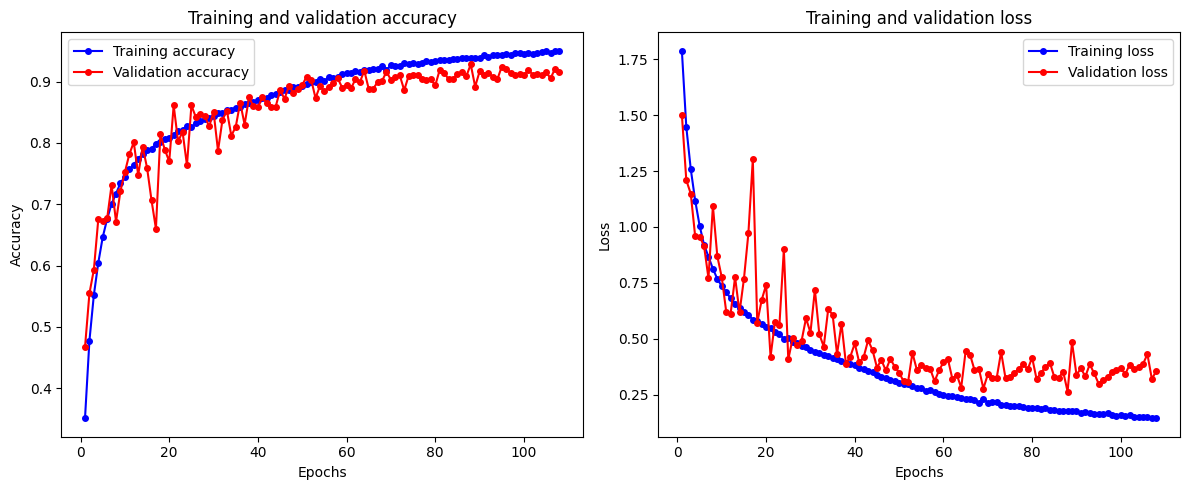

In [16]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Lấy giá trị loss và accuracy từ lịch sử huấn luyện
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Vẽ đồ thị Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy', markersize=4)
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy', markersize=4)
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Vẽ đồ thị Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss', markersize=4)
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss', markersize=4)
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Hiển thị đồ thị
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [17]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9259 - loss: 0.2840
Test Loss: 0.2809124290943146
Test Accuracy: 0.9262999892234802
